In [1]:
# import sys
# sys.path.append(r"C:\Users\Documents\Code\TicTacToe\gym-TicTacToe")

import numpy as np
from numpy.random import default_rng
rng = default_rng()
import matplotlib.pyplot as plt
import gym
from gym import spaces
import pygame
import gym_TicTacToe
import time

In [2]:
env = gym.make("gym_TicTacToe/TicTacToe-v0", render_mode="human")
observation, info = env.reset()
#env.step(env.action_space.sample())
#env.step(env.action_space.sample())
env.render()
observation, info

for turn in range(9):
  observation, reward, terminated,_,_ = env.step(env.get_random_move())
  #env.render()
  print(observation, reward)
  time.sleep(1)
  if terminated:
    break;

env.close()

/Users/jordanbarker/miniconda3/envs/ml4t/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


[ 0  0  0  0  0 -1  0  0  0] -0.25
[ 0  0  0  1  0 -1  0  0  0] -0.25
[ 0  0 -1  1  0 -1  0  0  0] -0.25
[ 0  0 -1  1  1 -1  0  0  0] -0.25
[ 0  0 -1  1  1 -1  0 -1  0] -0.25
[ 0  1 -1  1  1 -1  0 -1  0] -0.25
[ 0  1 -1  1  1 -1 -1 -1  0] -0.25
[ 1  1 -1  1  1 -1 -1 -1  0] 0.25


In [3]:
env.close()

: 

In [3]:
# Populate board for testing
board = np.zeros((3, 3))
player = [1, -1][rng.integers(2)]
for round in range(9):
  available_moves = np.where(board == 0)
  num_moves = len(available_moves[0])
  random_choice = rng.integers(num_moves)
  board[available_moves[0][random_choice], available_moves[1][random_choice]] = player
  player = player * -1
board

array([[-1.,  1., -1.],
       [ 1.,  1.,  1.],
       [-1.,  1., -1.]])

# Reinforcement Learning

Reference: https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html


In [38]:
import math
import random
import matplotlib
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

env = gym.make("gym_TicTacToe/TicTacToe-v0")

# set up matplotlib
is_ipython = "inline" in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Transition = namedtuple("Transition", ("state", "action", "next_state", "reward"))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


class DQN(nn.Module):
    def __init__(self, n_observations, n_actions, layer_size=32):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, layer_size)
        self.layer2 = nn.Linear(layer_size, layer_size)
        self.layer3 = nn.Linear(layer_size, n_actions)

    # Called with either one element to determine next action, or a batch during optimization
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)


optimize_step = 0
def optimize_model():
    global optimize_step
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for detailed explanation). 
    # This converts batch-array of Transitions to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(
        tuple(map(lambda s: s is not None, batch.next_state)),
        device=device,
        dtype=torch.bool,
    )
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    #print(state_batch.shape, action_batch.shape, reward_batch.shape)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    
    # # Print every 100 steps
    # if optimize_step % 100 == 0:
    #     print(f"Step {optimize_step}: Loss: {loss.item()}")
    #     for name, param in policy_net.named_parameters():
    #         if param.grad is not None:
    #             print(f"Step {optimize_step}: Gradient -- {name}: {param.grad.data.norm(2).item()}")
                
    # optimize_step += 1
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

def select_action(observation):
    global steps_done
    steps_done += 1
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1.0 * steps_done / EPS_DECAY)
    if sample > eps_threshold:
        with torch.no_grad():
            return select_best_valid_action(observation)

    # Randomly select move based on eps or if policy net move is invalid.
    return torch.tensor([[env.get_random_move()]], device=device, dtype=torch.int8)

def select_best_valid_action(observation):
    """
    Selects the best valid action based on the output of the policy network.

    :param policy_net_output: A tensor with the output of the policy network.
    :return: The index of the best valid action.
    """
    # Sort the actions based on their values in descending order
    policy_net_output = policy_net(observation)
    sorted_indices = torch.argsort(policy_net_output, descending=True)[0]

    # Iterate over the sorted indices and return the first valid action
    for idx in sorted_indices:
        if idx.item() in env.get_available_moves():
            return idx.view(1,1)
            
    # return random action as a fallback
    return torch.tensor([[env.get_random_move()]], device=device, dtype=torch.int8)


BATCH_SIZE = 32  # BATCH_SIZE is the number of transitions sampled from the replay buffer
GAMMA = 0.99  # GAMMA is the discount factor
EPS_START = 0.9  # EPS_START is the starting value of epsilon
EPS_END = 0.05  # EPS_END is the final value of epsilon
EPS_DECAY = 1000  # EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
TAU = 0.005  # TAU is the update rate of the target network
LR = 1e-4  # LR is the learning rate of the AdamW optimizer

observation, info = env.reset()
n_observations = len(observation)
n_actions = env.action_space.n

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

steps_done = 0
episode_durations = []

def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title("Result")
    else:
        plt.clf()
        plt.title("Training...")
    
    plt.xlabel("Episode")
    plt.ylabel("Duration")
    plt.plot(durations_t.numpy())
    if len(durations_t) >= 100:
        # Take 100 episode averages and plot them too
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

Complete


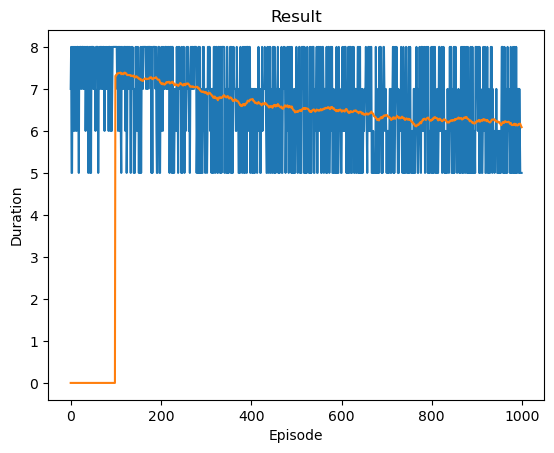

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [39]:
num_episodes = 1000

for i_episode in range(num_episodes):

    # Initialize the environment and get it's state/observation
    observation, info = env.reset()
    observation = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
    players_turn = info['players_turn']
    
    for t in count():
        if players_turn == 1: # Player 1 chooses randomly
            action = torch.tensor([[env.get_random_move()]], device=device, dtype=torch.int8)
            observation, _, terminated, _, _ = env.step(action.item())
            observation = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
        else: # Player -1 is the Q-learner
            action = select_action(observation)
            observation_prev = observation
            observation, reward, terminated, _, _ = env.step(action.item())
            observation = None if terminated else torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
            reward = torch.tensor([reward], device=device)

            # Store the transition in memory
            memory.push(observation_prev, action, observation, reward)

            # Perform one step of the optimization (on the policy network)
            optimize_model()

            # Soft update of the target network's weights
            # θ′ ← τ θ + (1 −τ )θ′
            target_net_state_dict = target_net.state_dict()
            policy_net_state_dict = policy_net.state_dict()
            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key] * \
                    TAU + target_net_state_dict[key] * (1 - TAU)
            target_net.load_state_dict(target_net_state_dict)

        if terminated:
            episode_durations.append(t + 1)
            if len(episode_durations) % 100 == 0:
                plot_durations()
            break
        players_turn *= -1 # Alternate player turns

print("Complete")
plot_durations(show_result=True)
plt.ioff()
plt.show()

# View model plays

In [40]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib import cm

def normalize_values(values):
    min_val = torch.min(values)
    max_val = torch.max(values)
    normalized = (values - min_val) / (max_val - min_val)
    return normalized.numpy()*100

def draw_board(axes, board, round, q_values=None):
    axes[round].set(title=f"Round {round + 1}")
    axes[round].axis("off")
    axes[round].set_xlim(-0.5, 2.5)
    axes[round].set_ylim(-0.5, 2.5)
    axes[round].plot([0.5, 0.5], [-0.5, 2.5], color="black", linewidth=3)
    axes[round].plot([1.5, 1.5], [-0.5, 2.5], color="black", linewidth=3)
    axes[round].plot([-0.5, 2.5], [0.5, 0.5], color="black", linewidth=3)
    axes[round].plot([-0.5, 2.5], [1.5, 1.5], color="black", linewidth=3)

    # Plot each square with color based on Q-value
    if q_values is not None:
        # cmap = cm.get_cmap('Blues')
        cmap = plt.colormaps['Blues']
        for i in range(3):
            for j in range(3):
                color = cmap(int(q_values[i * 3 + j]))
                axes[round].add_patch(plt.Rectangle((j-0.5, 1.5-i), 1, 1, color=color, alpha=0.8))

    taken_spaces = np.where(board != 0)
    for i in range(len(taken_spaces[0])):
        player = "O" if board[taken_spaces[0][i], taken_spaces[1][i]] == 1 else "X"
        axes[round].annotate(
            player, (taken_spaces[1][i], 2 - taken_spaces[0][i]), # Invert the y-coordinate here
            color='black', size=20, ha="center", va="center", weight='bold'
        )

def play_game():
    fig, axes = plt.subplots(1, 9, figsize=(18, 2))
    observation, info = env.reset()
    players_turn = info['players_turn']
    final_round = None  # Track the last round played

    for round in range(9):
        if players_turn == 1: # Player 1 ("O") chooses randomly
            q_values=None
            action = torch.tensor([[env.get_random_move()]], device=device, dtype=torch.int8)
        else: # Player -1 ("X") is the Q-learner
            observation = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
            q_values = policy_net(observation).detach().squeeze()
            q_values = normalize_values(q_values)
            action = select_best_valid_action(observation)
            # print(f"\nRound {round+1}")
            # print(observation)
            # print(q_values)
            board = np.zeros(3*3)
            board[action] = 1
            #print(f"Best action: {action[0].item()} \n", np.flipud(board.reshape(3,3)))
        
        observation, _, terminated, _, _ = env.step(action.item())
        board = observation.reshape(3,3)
        draw_board(axes, board, round, q_values=q_values)
        if terminated:
            final_round = round
            break
        players_turn *= -1 # Alternate player turns

    # If the game ends early, fill the remaining axes
    for round in range(final_round + 1, 9):
        # You can either clear the extra axes
        axes[round].clear()
        axes[round].axis('off')
    plt.show()


# play_game()
# play_game()
# play_game()

Game 1


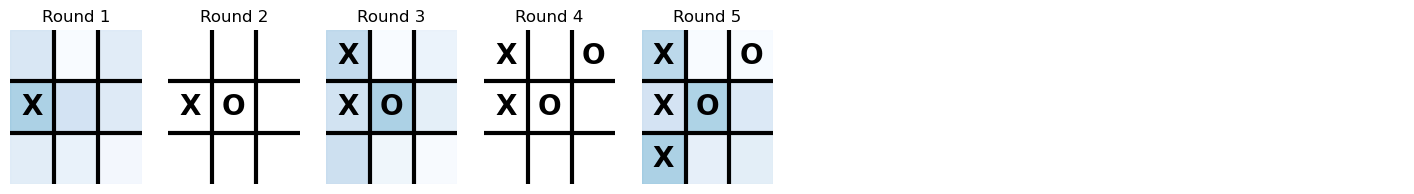

Game 2


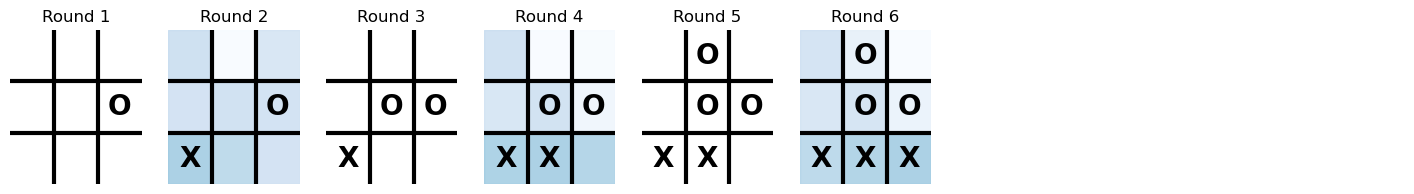

Game 3


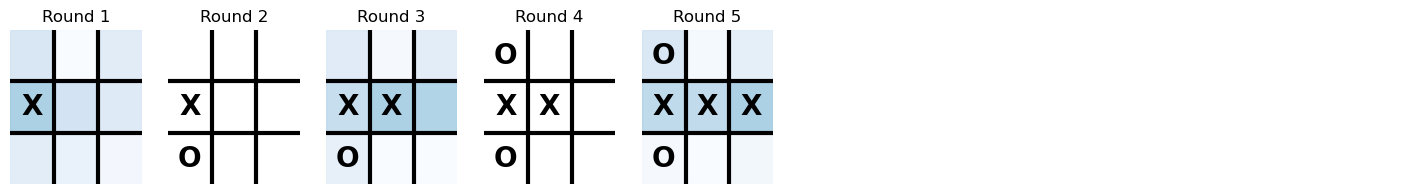

Game 4


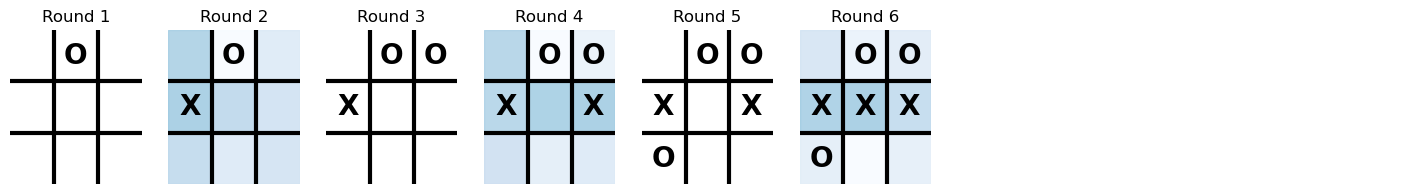

Game 5


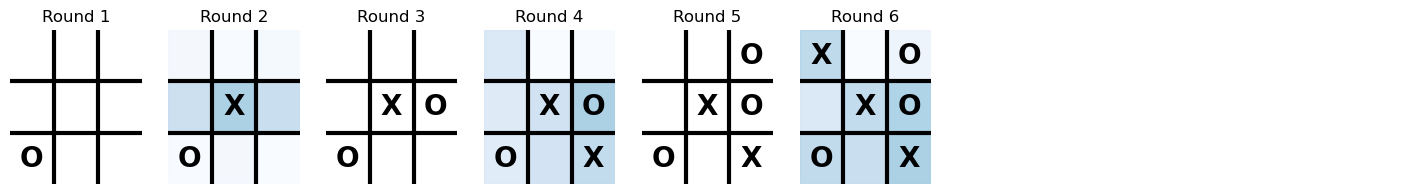

In [41]:
for i in range(5):
    print("Game", i+1)
    play_game()

Game 1


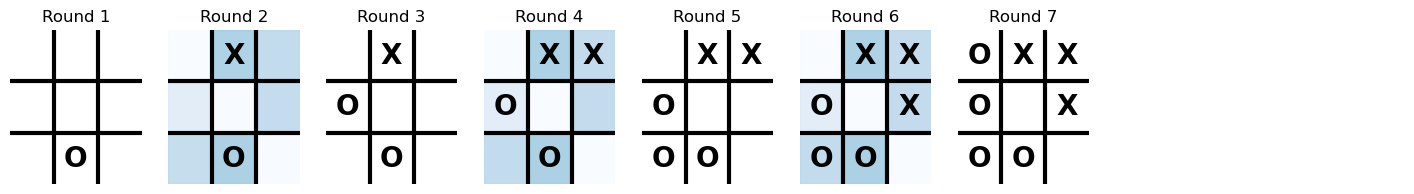

Game 2


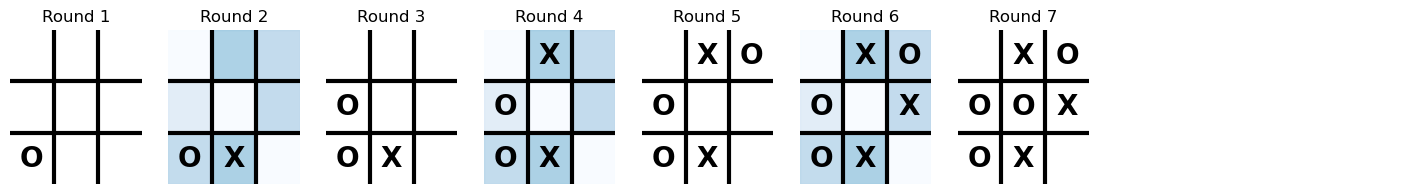

Game 3


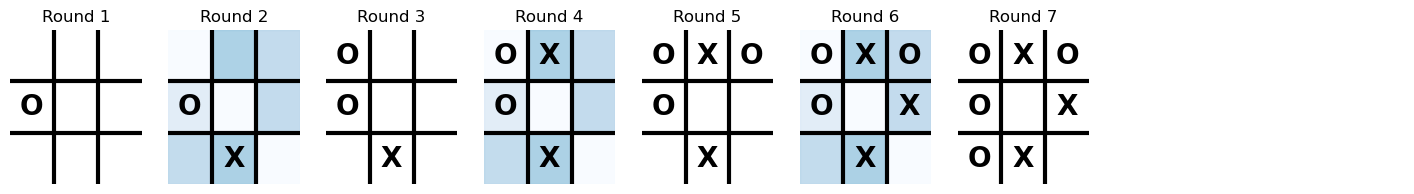

Game 4


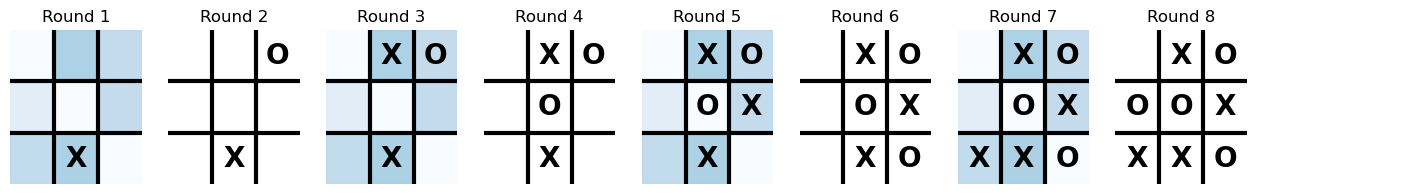

Game 5


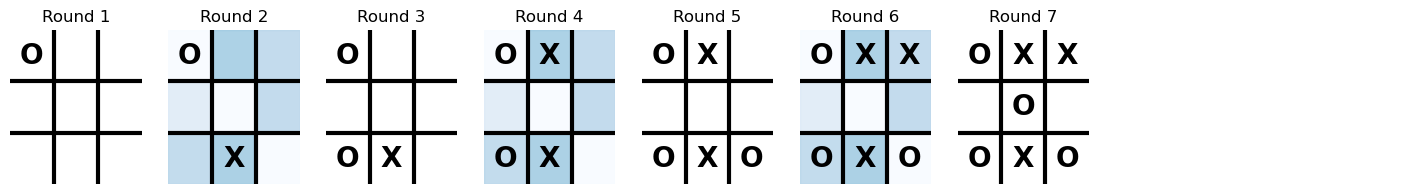

In [15]:
for i in range(5):
    print("Game", i+1)
    play_game()

In [50]:
observation

tensor([[ 0., -1.,  1., -1.,  1., -1.,  1.,  0.,  1.]])

In [16]:
observation = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

policy_net(observation).detach().squeeze()
# q_values = normalize_values(q_values)
# action = select_best_valid_action(observation)

/var/folders/tl/00b3nkg57wz5g7fsvwlb_76m0000gn/T/ipykernel_3150/2426814037.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  observation = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)


tensor([7.3906e+01, 8.2396e+05, 6.5544e+05, 3.0317e+05, 5.1301e-01, 6.5061e+05,
        6.4137e+05, 8.3089e+05, 1.1193e+02])


Round 1
[ 0  0 -1  0  0  0  0  0  0]
[ 51.901783   41.927235  100.         13.553703   38.922028    7.3467145
  34.686115    0.          3.321969 ]
[[ 0  0 -1]
 [ 0  0  0]
 [ 0  0  0]]

Round 2
[ 1  0 -1  0  0  0  0  0  0]
None
[[ 1  0 -1]
 [ 0  0  0]
 [ 0  0  0]]

Round 3
[ 1 -1 -1  0  0  0  0  0  0]
[ 55.06614   42.371223 100.        14.892599  41.77629    9.381773
  37.159817   0.         3.243559]
[[ 1 -1 -1]
 [ 0  0  0]
 [ 0  0  0]]

Round 4
[ 1 -1 -1  0  0  1  0  0  0]
None
[[ 1 -1 -1]
 [ 0  0  1]
 [ 0  0  0]]

Round 5
[ 1 -1 -1  0 -1  1  0  0  0]
[ 55.712433   45.948208  100.         14.614685   32.626415    7.317281
  28.228188    0.1626263   0.       ]
[[ 1 -1 -1]
 [ 0 -1  1]
 [ 0  0  0]]

Round 6
[ 1 -1 -1  1 -1  1  0  0  0]
None
[[ 1 -1 -1]
 [ 1 -1  1]
 [ 0  0  0]]

Round 7
[ 1 -1 -1  1 -1  1 -1  0  0]
[ 53.406036   42.290638  100.         15.606245   35.3512      8.34333
  33.423122    0.          2.0543137]
[[ 1 -1 -1]
 [ 1 -1  1]
 [-1  0  0]]


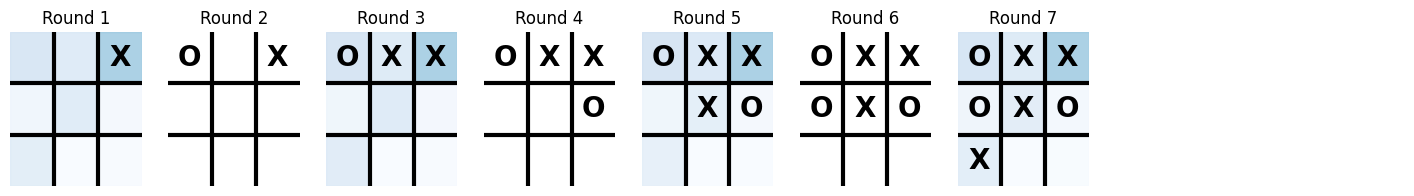

In [23]:
def play_game_debug():
    fig, axes = plt.subplots(1, 9, figsize=(18, 2))
    observation, info = env.reset()
    players_turn = info['players_turn']
    final_round = None  # Track the last round played

    for round in range(9):
        if players_turn == 1: # Player 1 ("O") chooses randomly
            q_values=None
            action = torch.tensor([[env.get_random_move()]], device=device, dtype=torch.int8)
        else: # Player -1 ("X") is the Q-learner
            observation = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
            q_values = policy_net(observation).detach().squeeze()
            q_values = normalize_values(q_values)
            action = select_best_valid_action(observation)
            # print(f"\nRound {round+1}")
            # print(observation)
            # print(q_values)
            board = np.zeros(3*3)
            board[action] = 1
            #print(f"Best action: {action[0].item()} \n", np.flipud(board.reshape(3,3)))
        
        observation, _, terminated, _, _ = env.step(action.item())
        board = observation.reshape(3,3)
        print(f"\nRound {round+1}")
        print(observation)
        print(q_values)
        print(board)
        draw_board(axes, board, round, q_values=q_values)
        if terminated:
            final_round = round
            break
        players_turn *= -1 # Alternate player turns

    # If the game ends early, fill the remaining axes
    for round in range(final_round + 1, 9):
        # You can either clear the extra axes
        axes[round].clear()
        axes[round].axis('off')
    plt.show()

play_game_debug()

In [11]:
# if policy_net(observation).max(1)[1].view(1,1).item() in env.get_available_moves()


action = torch.tensor([[env.get_random_move()]], device=device, dtype=torch.int8)
q_values = policy_net(observation).detach().squeeze()
q_values = normalize_values(q_values)
print(observation)
print(q_values)
print("Best action:",)
# policy_net(observation).max(1)[1].view(1,1).item(), policy_net(observation).max(1)[1].view(1,1), policy_net(observation)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0.]])
[ 51.901783   41.927235  100.         13.553703   38.922028    7.3467145
  34.686115    0.          3.321969 ]
Best action: tensor([[2]])


In [12]:
observation, _, terminated, _, _ = env.step(action.item())
observation = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
q_values = policy_net(observation).detach().squeeze()
q_values = normalize_values(q_values)
print(observation)
print(q_values)
print("Best action:",select_best_valid_action(observation))

tensor([[ 0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.]])
[ 53.81869   45.127434 100.        15.184609  36.366634   8.757895
  34.17455    0.         4.207367]
Best action: tensor([[0]])


In [90]:
policy_net(observation)

tensor([[50.7902, 50.4324, 54.5763, 42.9875, 45.5905, 43.7930, 42.3887, 39.1728,
         43.3058]], grad_fn=<AddmmBackward0>)

In [93]:
env.get_available_moves()

array([0, 2, 3, 4, 5, 6, 7, 8], dtype=int64)

In [101]:
idx, idx.item(), policy_net_output, torch.argsort(policy_net_output, descending=True)

(tensor(7),
 7,
 tensor([[50.7902, 50.4324, 54.5763, 42.9875, 45.5905, 43.7930, 42.3887, 39.1728,
          43.3058]], grad_fn=<AddmmBackward0>),
 tensor([[2, 0, 1, 4, 5, 8, 3, 6, 7]]))

In [109]:
torch.argsort(policy_net_output, descending=True)[0]#.item()

tensor([2, 0, 1, 4, 5, 8, 3, 6, 7])

In [ ]:
tensor([[2, 0, 1, 4, 5, 8, 3, 6, 7]])

In [112]:
env.get_available_moves()

array([0, 2, 3, 4, 5, 6, 7, 8], dtype=int64)

In [111]:
env.get_available_moves()[idx.item()]

8

2
0
4
5
8
3
6
7


In [129]:
def select_best_valid_action(observation):
    """
    Selects the best valid action based on the output of the policy network.

    :param policy_net_output: A tensor with the output of the policy network.
    :return: The index of the best valid action.
    """
    # Sort the actions based on their values in descending order
    policy_net_output = policy_net(observation)
    sorted_indices = torch.argsort(policy_net_output, descending=True)[0]

    # Iterate over the sorted indices and return the first valid action
    for idx in sorted_indices:
        if idx.item() in env.get_available_moves():
            return idx.view(1,1)
    # If no valid actions, return None
    return None

select_best_valid_action(policy_net(observation))

tensor([[8]])

In [24]:
transitions = memory.sample(BATCH_SIZE)
transitions[:10]

[Transition(state=tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]]), action=tensor([[4]]), next_state=tensor([[ 1.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.]]), reward=tensor([-0.2500])),
 Transition(state=tensor([[ 1.,  0., -1.,  0., -1.,  1.,  0.,  0.,  0.]]), action=tensor([[6]]), next_state=tensor([[ 1.,  0., -1.,  0., -1.,  1., -1.,  0.,  0.]]), reward=tensor([1])),
 Transition(state=tensor([[ 0.,  1.,  1.,  0., -1., -1.,  1.,  0., -1.]]), action=tensor([[0]]), next_state=tensor([[-1.,  1.,  1.,  0., -1., -1.,  1.,  0., -1.]]), reward=tensor([1])),
 Transition(state=tensor([[ 0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  1.]]), action=tensor([[2]]), next_state=tensor([[ 0.,  0., -1.,  0.,  0.,  0., -1.,  0.,  1.]]), reward=tensor([-0.2500])),
 Transition(state=tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0.]]), action=tensor([[2]]), next_state=tensor([[ 0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.]]), reward=tensor([-0.2500])),
 Transition(state=tensor([[ 0., -1., -1.,  0.,  0.,  1.,  1.,  0.,  0.

In [25]:
transitions[2].state.reshape(3,3)

tensor([[ 0.,  1.,  1.],
        [ 0., -1., -1.],
        [ 1.,  0., -1.]])

In [26]:
transitions[2].next_state.reshape(3,3)

tensor([[-1.,  1.,  1.],
        [ 0., -1., -1.],
        [ 1.,  0., -1.]])

In [29]:
batch = Transition(*zip(*transitions))
non_final_mask = torch.tensor(
    tuple(map(lambda s: s is not None, batch.next_state)),
    device=device,
    dtype=torch.bool,
)
non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
non_final_mask, non_final_next_states

(tensor([True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True]),
 tensor([[ 1.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 1.,  0., -1.,  ..., -1.,  0.,  0.],
         [-1.,  1.,  1.,  ...,  1.,  

In [41]:
state_batch = torch.cat(batch.state)
action_batch = torch.cat(batch.action)
reward_batch = torch.cat(batch.reward)
state_action_values = policy_net(state_batch).gather(1, action_batch)
next_state_values = torch.zeros(BATCH_SIZE, device=device)
with torch.no_grad():
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
# Compute the expected Q values
expected_state_action_values = (next_state_values * GAMMA) + reward_batch
# GAMMA, reward_batch, next_state_values, expected_state_action_values
# Compute Huber loss
criterion = nn.SmoothL1Loss()
loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
optimizer.zero_grad()
loss.backward()
torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
optimizer.step()

In [42]:
state_action_values

tensor([[131.4727],
        [171.0643],
        [122.2021],
        [167.4568],
        [153.2071],
        [197.9800],
        [166.0380],
        [129.2001],
        [160.2756],
        [113.9097],
        [181.4579],
        [232.6203],
        [214.6505],
        [195.6632],
        [185.3145],
        [130.1539],
        [169.2233],
        [151.9648],
        [113.7692],
        [182.3386],
        [131.4727],
        [197.4608],
        [199.3616],
        [207.8167],
        [183.1106],
        [192.7307],
        [130.3813],
        [202.9764],
        [181.7255],
        [185.2500],
        [143.9347],
        [176.2543],
        [176.2543],
        [178.0670],
        [150.5949],
        [192.3976],
        [193.5846],
        [188.9070],
        [139.0145],
        [174.8818],
        [178.0321],
        [180.6385],
        [129.2001],
        [129.2001],
        [125.0794],
        [156.5194],
        [134.2312],
        [178.9544],
        [100.7568],
        [151.8437],


In [ ]:
transitions = memory.sample(BATCH_SIZE)
# Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
# detailed explanation). This converts batch-array of Transitions
# to Transition of batch-arrays.
batch = Transition(*zip(*transitions))

# Compute a mask of non-final states and concatenate the batch elements
# (a final state would've been the one after which simulation ended)
non_final_mask = torch.tensor(
    tuple(map(lambda s: s is not None, batch.next_state)),
    device=device,
    dtype=torch.bool,
)
non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

state_batch = torch.cat(batch.state)
action_batch = torch.cat(batch.action)
reward_batch = torch.cat(batch.reward)
#print(state_batch.shape, action_batch.shape, reward_batch.shape)

# Compute Q(s_t, a) - the model computes Q(s_t), then we select the
# columns of actions taken. These are the actions which would've been taken
# for each batch state according to policy_net
state_action_values = policy_net(state_batch).gather(1, action_batch)

# Compute V(s_{t+1}) for all next states.
# Expected values of actions for non_final_next_states are computed based
# on the "older" target_net; selecting their best reward with max(1)[0].
# This is merged based on the mask, such that we'll have either the expected
# state value or 0 in case the state was final.
next_state_values = torch.zeros(BATCH_SIZE, device=device)
with torch.no_grad():
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
# Compute the expected Q values
expected_state_action_values = (next_state_values * GAMMA) + reward_batch

# Compute Huber loss
criterion = nn.SmoothL1Loss()
loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

# Optimize the model
optimizer.zero_grad()
loss.backward()
# In-place gradient clipping
torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
optimizer.step()

# Save Model

In [ ]:
torch.save(target_net.state_dict())
#torch.save(policy_net.state_dict(), PATH)

In [ ]:
# Load model
model = TheModelClass(*args, **kwargs)
model.load_state_dict(torch.load(PATH))
model.eval()